In [2]:
import pandas as pd
import numpy as np
import theano.tensor as tt
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
from Clean import Clean

%matplotlib inline

In [3]:
df = pd.read_csv('FM_2000-2019.csv')
print(df.shape)
df_all = df[df['gp_all_0_a'] >= 30]
df = df_all[0:-100]
df_test = df_all[-100:]
print(df.shape)

(24171, 459)
(14392, 459)


In [4]:
games = 30
q = 1

clean = Clean(df,games)
features = clean.get_features(['e-def-rating','e-off-rating','e-pace'],q)
y = clean.get_target(q).values

In [5]:
cols = features.columns
x = features.values
x1 = x
print(type(x))
print(x.shape)

print(type(y))

<class 'numpy.ndarray'>
(14195, 24)
<class 'numpy.ndarray'>


In [6]:
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=1, shape=x.shape[1])
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Expected value of outcome
    mu = alpha + pm.math.dot(x,beta)

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=y)

In [7]:
with basic_model:
    # instantiate sampler
    # draw 500 posterior samples
    trace = pm.sample(cores=4,target_accept = 0.95)
    # trace = pm.sample(cores=1)
    #pm.summary(trace).round(2)
    #pm.plot_posterior(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains: 100%|██████████| 4000/4000 [09:53<00:00,  6.74draws/s]
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.


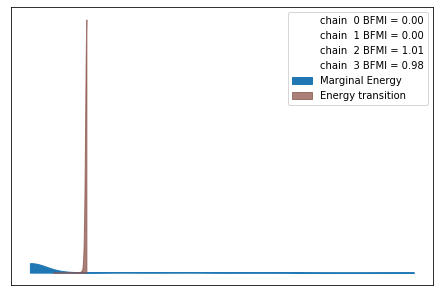

In [9]:
pm.energyplot(trace)


In [21]:
with basic_model:
    post_pred = pm.sample_posterior_predictive(trace, samples=500)


100%|██████████| 500/500 [00:00<00:00, 661.46it/s]


In [22]:
post_pred['Y_obs']

array([[353.45662472, 314.99811265, 331.39665521, ..., 333.52773125,
        338.10154639, 347.91371539],
       [351.69129865, 315.21817508, 330.39388898, ..., 334.44693482,
        339.0951589 , 348.78530767],
       [354.73168406, 309.37083379, 332.70713478, ..., 336.81383848,
        339.72515391, 348.26375516],
       ...,
       [358.27153853, 326.45199987, 316.30891193, ..., 347.36318149,
        338.25959148, 330.51089993],
       [352.90692694, 296.70184438, 337.87609444, ..., 334.69947547,
        339.02703422, 349.95969195],
       [354.50461854, 337.1327707 , 325.52648078, ..., 313.90715989,
        347.35962328, 356.85348235]])

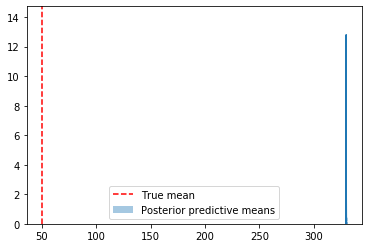

In [23]:
fig, ax = plt.subplots()
sns.distplot(post_pred['Y_obs'].mean(axis=1), label='Posterior predictive means', ax=ax)
ax.axvline(y.mean(), ls='--', color='r', label='True mean')
ax.legend(); 